### Importamos las librerias


In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import math as mt
import numpy as np
import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

### Cargamos los datos preprocesados, lo procesamos y los Visualizamos

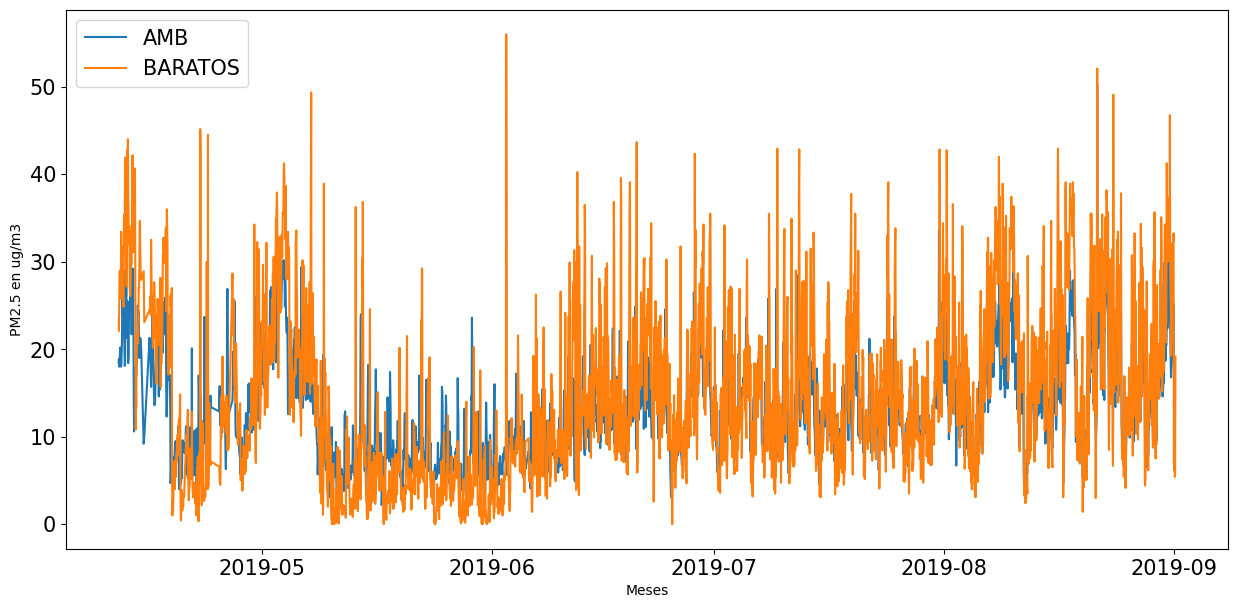

In [3]:
data = pd.read_excel('Datos AMB.xlsx')
data1 = pd.read_csv('Datos Baratos.csv',sep=",",parse_dates=['fecha_hora_med'])
DataAMB_CORREGIDO = pd.read_excel('Datos AMB2.xlsx')

# Limpieza de datos
data1 = data1.drop(['id_parametro'], axis =1)
data['Medidas'] = data['Medidas'].replace('NoData', '')
data = data.dropna()
data1 = data1.dropna()

# Sincronizacion de fechas
#DataAMB_CORREGIDO['Diferencias de horas'] = data1['fecha_hora_med'] - DataAMB_CORREGIDO['Fechas']
#data1['fecha_hora_med'] = data1['fecha_hora_med'] - DataAMB_CORREGIDO['Diferencias de horas']

data1['fecha_hora_med']     = pd.to_datetime(data1['fecha_hora_med'])
data['Fechas']              = pd.to_datetime(data['Fechas'])
DataAMB_CORREGIDO['Fechas'] = pd.to_datetime(DataAMB_CORREGIDO['Fechas'])
data1 = data1.sort_values('fecha_hora_med',ascending=True)

data = data.drop_duplicates()
data1 = data1.drop_duplicates()
# Plot
plt.figure(figsize=(15,7))

DATOS_AMB = plt.plot(DataAMB_CORREGIDO['Fechas'], DataAMB_CORREGIDO['Medidas'], label='AMB')
DATOS_BAJA_CALIDAD = plt.plot(data1['fecha_hora_med'], data1['valor'], label='BARATOS')
plt.xlabel('Meses')
plt.ylabel('PM2.5 en ug/m3')
plt.legend(fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

# Promedio movil con varios tipos de configuraciones

#### Promedio con la ventana = 3 y con los pasos = 1

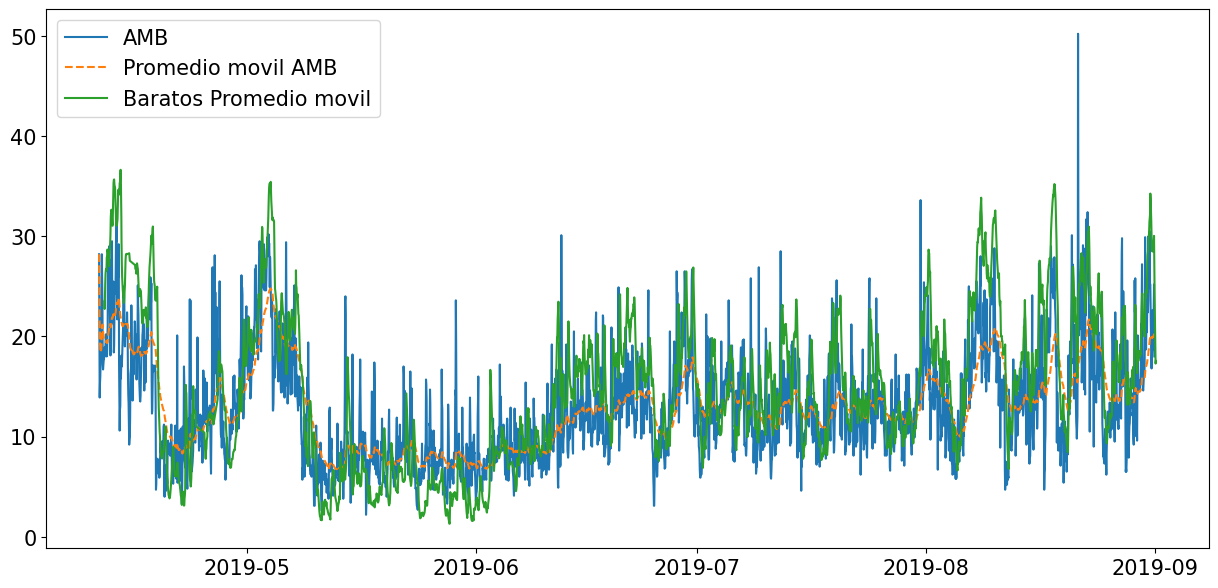

,fecha_hora_med,valor,moving average_3,calibrados
396,2019-04-11 17:29:20.949,23.500000,23.500000,19.223542
395,2019-04-11 18:02:49.625,22.083334,22.737180,18.729334
394,2019-04-11 19:02:50.638,25.250000,23.706693,19.699396
393,2019-04-11 20:03:00.961,28.749998,25.272171,21.071186
392,2019-04-11 21:02:49.634,29.000000,26.263260,21.466691
...,...,...,...,...
2606,2019-09-01 00:02:50.912,6.166667,23.791139,12.451794
2605,2019-09-01 01:02:49.911,7.833333,21.511452,12.486528
2604,2019-09-01 02:02:49.912,5.416667,19.212197,11.696380
2603,2019-09-01 03:02:49.912,5.750000,17.289026,11.624129


In [102]:
color = ['limegreen', '#bc15b0', 'indigo']
linestyle = ['-','--','-.']
plt.figure(figsize=(15,7))

#Promedio movil con la ventana = 3 y con el paso = 1
data1['moving average_3'] = data1['valor'].ewm(com=6).mean()
data['moving average_3'] = data['Medidas'].ewm(span =60).mean()
#data['moving average_3'] = data['Medidas'].ewm(span =3).mean()
DataAMB_CORREGIDO['moving average_3'] = DataAMB_CORREGIDO['Medidas'].rolling(6,1).mean()

plt.plot(data['Fechas'], data['Medidas'], label='AMB')
PROMEDIO_MOVIL = plt.plot(data['Fechas'], data['moving average_3'], '--',label='Promedio movil AMB')
plt.plot(data1['fecha_hora_med'], data1['moving average_3'], label='Baratos Promedio movil')
plt.legend(fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()
data1

# Prediccion y calibracion de las medidas

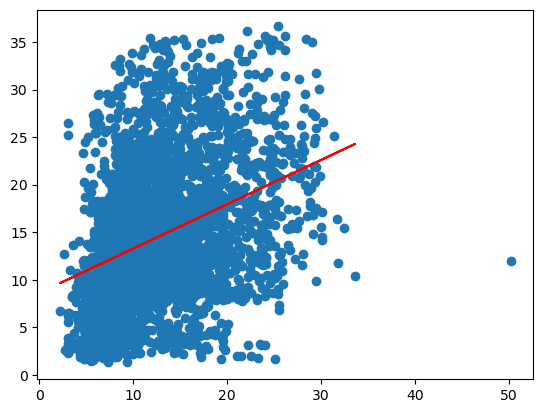

Coeficientes: 
 [[0.46589739]]
Termino independiente: 
 [8.6218542]
Error cuadratico Medio: 11.99
Varianza: 0.61


,fecha_hora_med,valor,moving average_3,calibrados
396,2019-04-11 17:29:20.949,23.500000,23.500000,19.570443
395,2019-04-11 18:02:49.625,22.083334,22.737180,19.215047
394,2019-04-11 19:02:50.638,25.250000,23.706693,19.666741
393,2019-04-11 20:03:00.961,28.749998,25.272171,20.396093
392,2019-04-11 21:02:49.634,29.000000,26.263260,20.857838
...,...,...,...,...
2606,2019-09-01 00:02:50.912,6.166667,23.791139,19.706084
2605,2019-09-01 01:02:49.911,7.833333,21.511452,18.643984
2604,2019-09-01 02:02:49.912,5.416667,19.212197,17.572767
2603,2019-09-01 03:02:49.912,5.750000,17.289026,16.676766


In [103]:
#Funcion de calibracion
data_copy = data.copy()
data_copy = data[(data['Fechas'] <= ('2019-08-27 20:00:00'))]
#DataAMB_CORREGIDO = DataAMB_CORREGIDO[(DataAMB_CORREGIDO['Fechas'] <= ('2019-08-31 23:00:00'))]
#data1 = data1[(data1['fecha_hora_med'] <= ('2019-08-31 22:00:00'))]

data_copy = data_copy.dropna()
data = data.dropna()
data1 = data1.dropna()
DataAMB_CORREGIDO = DataAMB_CORREGIDO.dropna()

Y = data1['moving average_3'].values.reshape(-1, 1)
X = data_copy['Medidas'].values.reshape(-1, 1)

#X = DataAMB_CORREGIDO['moving average_3'].values.reshape(-1, 1)
#Y = data1['moving average_3'].values.reshape(-1, 1)



X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state = 0)

slr = LinearRegression()
slr.fit(X_train, y_train)
y_pred = slr.predict(X_test)


Valor_Estacion_barata = data1['moving average_3']
V = (np.array([Valor_Estacion_barata]).reshape(-1,1))
data1['calibrados'] = slr.predict(V)

plt.scatter(data_copy['Medidas'],  data1['moving average_3'])
plt.plot(X_test,y_pred, color = 'RED')
plt.show()

# Coeficienetes obtenidos
print('Coeficientes: \n', slr.coef_)
# Este es el valor donde corta el eje Y (en X=0)
print('Termino independiente: \n', slr.intercept_)
# Error Cuadrado Medio
print("Error cuadratico Medio: %.2f" % mean_squared_error(X_test,y_pred))
# Puntaje de Varianza. El mejor puntaje es un 1.0
print('Varianza: %.2f' % r2_score(X_test,y_pred ))
data1

In [104]:
#Distancia de las medidas


ErrorCuadraticoMedio =  ((((data_copy['moving average_3'] - data1['calibrados'])**2).mean()))

distancia_AMB_BARATAS = mt.sqrt((((data_copy['moving average_3'] - data1['valor'])**2)).sum())

distancias_ventanas_moviles =  mt.sqrt((((data_copy['moving average_3'] - data1['moving average_3'])**2)).sum())

Distancia_AMB_con_Barata_Calibrados = mt.sqrt((((data_copy['moving average_3'] - data1['calibrados'])**2)).sum())

Distancia_AMB_con_Barata_Calibrados

353.914125935598

In [105]:
distancia_AMB_BARATAS

616.9970227598463

In [106]:
ErrorCuadraticoMedio

37.76159437345742

In [107]:
distancias_ventanas_moviles

522.3153166417152

## Graficas comprando los datos sin calibrar con los calobrados y su error

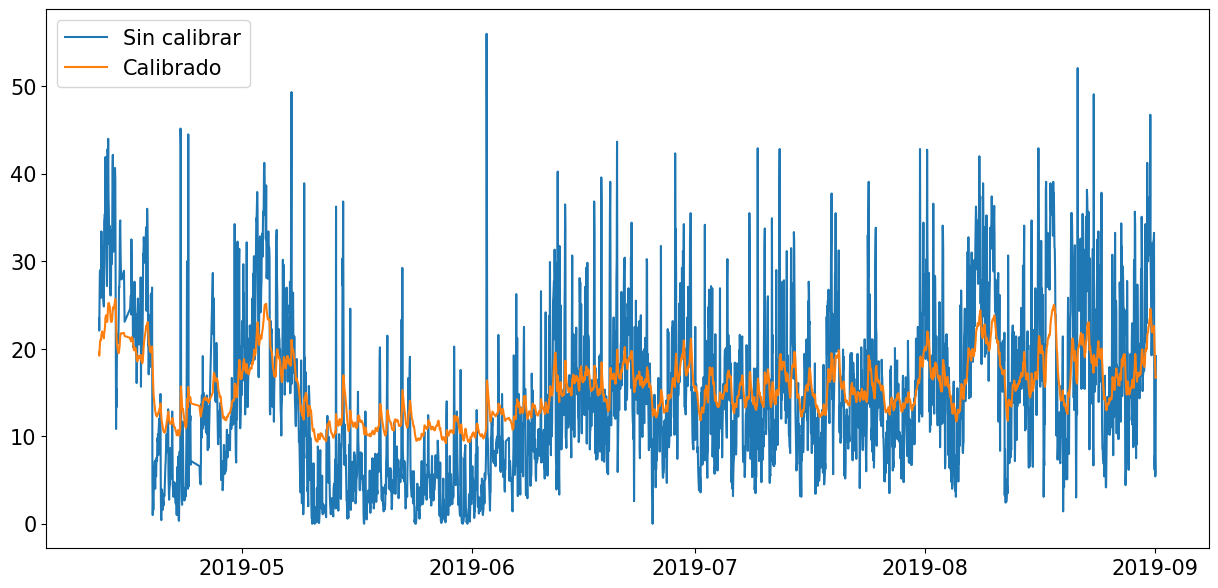

In [108]:
plt.figure(figsize=(15,7))
plt.plot(data1['fecha_hora_med'], data1['valor'], label='Sin calibrar')
plt.plot(data1['fecha_hora_med'], data1['calibrados'], label='Calibrado')
plt.legend(fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

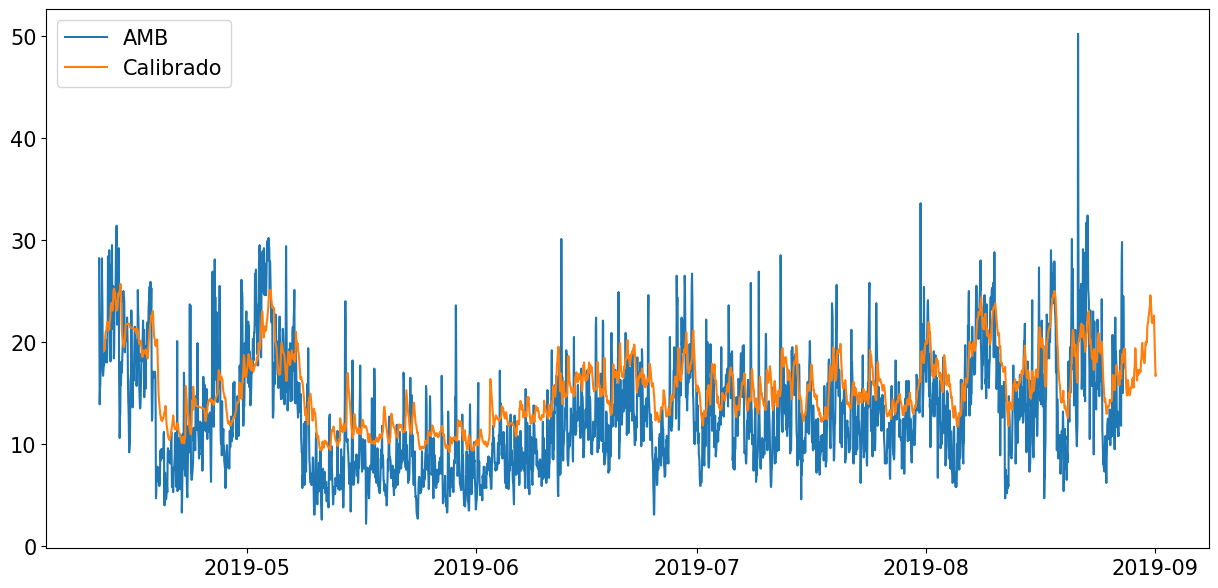

In [109]:
plt.figure(figsize=(15,7))
plt.plot(data_copy['Fechas'], data_copy['Medidas'], label='AMB')
plt.plot(data1['fecha_hora_med'], data1['calibrados'], label='Calibrado')
plt.legend(fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()
